In [ ]:
# Instalar los paquetes necesarios
!pip install fuzzywuzzy
!pip install python-Levenshtein  # Opcional, pero acelera fuzzywuzzy
!pip install nltk

In [25]:
# Pipeline ETL para Datos de Ensayos Clínicos de Pfizer
# Implementación de técnicas de limpieza y transformación

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import re
from fuzzywuzzy import fuzz, process
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import matplotlib.pyplot as plt
import plotly.express as px

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# 1. CARGA DE DATOS (Simulada para este ejemplo)
def cargar_datos_clinicos(ruta_archivo):
    """
    Carga datos de ensayos clínicos desde múltiples fuentes
    """
    print(f"Cargando datos desde {ruta_archivo}")
    # En un caso real, conectaríamos con múltiples fuentes
    # Para este ejemplo, simulamos con datos de muestra
    data = pd.DataFrame({
        'patient_id': ['P'+str(i) for i in range(1, 101)],
        'age': np.random.normal(55, 15, 100),
        'gender': np.random.choice(['M', 'F', 'Male', 'Female', 'm', 'f'], 100),
        'treatment_group': np.random.choice(['A', 'B', 'Placebo', 'Control'], 100),
        'baseline_measure': np.random.normal(120, 20, 100),
        'week_4_measure': np.random.normal(110, 25, 100),
        'week_8_measure': np.random.normal(105, 30, 100),
        'adverse_event': np.random.choice(['None', 'Mild', 'Moderate', 'Severe', None], 100),
        'site_id': np.random.choice(['US-001', 'US-002', 'EU-001', 'EU-002', 'ASIA-001'], 100),
        'notes': [f"Patient {i} exhibited standard response" if i % 10 != 0 else None for i in range(1, 101)]
    })

    # Introducimos valores faltantes simulados
    for col in ['week_4_measure', 'week_8_measure', 'adverse_event']:
        missing_idx = np.random.choice(data.index, size=int(len(data)*0.15), replace=False)
        data.loc[missing_idx, col] = np.nan

    # Introducimos outliers simulados
    outlier_idx = np.random.choice(data.index, size=5, replace=False)
    data.loc[outlier_idx, 'week_8_measure'] = data.loc[outlier_idx, 'week_8_measure'] * 3

    return data

In [ ]:
# 2. LIMPIEZA Y NORMALIZACIÓN
def limpiar_normalizar_datos(df):
    """
    Implementa técnicas de limpieza y normalización para datos clínicos
    """
    print("Iniciando limpieza y normalización de datos...")
    df_clean = df.copy()

    # 2.1 Normalización de categorías (ej: género)
    gender_mapping = {
        'M': 'Male', 'm': 'Male', 'MALE': 'Male',
        'F': 'Female', 'f': 'Female', 'FEMALE': 'Female'
    }
    df_clean['gender'] = df_clean['gender'].replace(gender_mapping)

    # 2.2 Detección y manejo de outliers en medidas clínicas
    cols_to_check = ['baseline_measure', 'week_4_measure', 'week_8_measure']

    for col in cols_to_check:
        # Calculamos límites usando el método IQR (más robusto que Z-score)
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        # Identificamos outliers
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)].index

        print(f"Detectados {len(outliers)} outliers en {col}")

        # Marcamos outliers con flag (no eliminamos, importante en datos clínicos)
        df_clean[f'{col}_is_outlier'] = False
        df_clean.loc[outliers, f'{col}_is_outlier'] = True

        # Opcionalmente, winsorización (recorte) para análisis estadísticos
        df_clean[f'{col}_winsorized'] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)

    # 2.3 Imputación de valores faltantes usando KNN (más adecuado para datos clínicos)
    cols_for_imputation = ['week_4_measure', 'week_8_measure']
    # Preparamos variables para el modelo de imputación
    features_for_imputation = df_clean[['age', 'baseline_measure']].copy()
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_for_imputation)

    # Aplicamos KNN imputation
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = df_clean.copy()
    df_imputed[cols_for_imputation] = imputer.fit_transform(
        np.hstack((features_scaled, df_clean[cols_for_imputation].values))
    )[:, 2:]

    # Marcamos valores imputados
    for col in cols_for_imputation:
        df_imputed[f'{col}_imputed'] = df_clean[col].isna()

    # 2.4 Normalización de identificadores de sitios
    site_pattern = re.compile(r'([A-Za-z]+)-(\d+)')

    def normalize_site_id(site_id):
        match = site_pattern.match(site_id)
        if match:
            region, number = match.groups()
            return f"{region.upper()}-{number.zfill(3)}"
        return site_id

    df_imputed['site_id'] = df_imputed['site_id'].apply(normalize_site_id)

    # 2.5 Tratamiento de texto en notas clínicas
    def clean_text(text):
        if pd.isna(text):
            return ""
        # Tokenización y eliminación de stopwords
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text.lower())
        filtered_tokens = [w for w in tokens if w not in stop_words]
        return " ".join(filtered_tokens)

    df_imputed['notes_cleaned'] = df_imputed['notes'].apply(clean_text)

    return df_imputed

In [ ]:
# 3. TRANSFORMACIÓN Y FEATURE ENGINEERING
def transformar_datos(df):
    """
    Implementa transformaciones avanzadas y generación de nuevas variables
    """
    print("Iniciando transformación y feature engineering...")
    df_transform = df.copy()

    # 3.1 Generación de variables derivadas clínicamente relevantes
    # Cambio absoluto y relativo desde línea base
    df_transform['change_week4'] = df_transform['week_4_measure'] - df_transform['baseline_measure']
    df_transform['change_week8'] = df_transform['week_8_measure'] - df_transform['baseline_measure']

    df_transform['pct_change_week4'] = (df_transform['change_week4'] / df_transform['baseline_measure']) * 100
    df_transform['pct_change_week8'] = (df_transform['change_week8'] / df_transform['baseline_measure']) * 100

    # 3.2 Clasificación de respondedores según criterios clínicos
    # (Simulamos un criterio típico en ensayos clínicos: >15% de mejora)
    df_transform['responder_status'] = np.where(df_transform['pct_change_week8'] < -15, 'Responder', 'Non-Responder')

    # 3.3 Agregación de eventos adversos (para análisis de seguridad)
    adverse_severity_mapping = {
        'None': 0,
        'Mild': 1,
        'Moderate': 2,
        'Severe': 3
    }
    df_transform['adverse_event_score'] = df_transform['adverse_event'].map(adverse_severity_mapping).fillna(0)

    # 3.4 Codificación de variables categóricas para modelado
    # One-hot encoding para variables nominales
    categorical_cols = ['gender', 'treatment_group', 'site_id']
    encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    encoded_data = encoder.fit_transform(df_transform[categorical_cols])

    # Convertimos a DataFrame con nombres apropiados
    encoded_cols = encoder.get_feature_names_out(categorical_cols)

    encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df_transform.index)

    # Combinamos con el dataframe original
    df_transform = pd.concat([df_transform, encoded_df], axis=1)

    # 3.5 Normalización de variables continuas para análisis y visualización
    numeric_cols = ['age', 'baseline_measure', 'week_4_measure', 'week_8_measure',
                   'change_week4', 'change_week8']

    scaler = StandardScaler()
    df_transform[['scaled_' + col for col in numeric_cols]] = scaler.fit_transform(df_transform[numeric_cols])

    # 3.6 Variables de agrupación para análisis estratificado
    df_transform['age_group'] = pd.cut(df_transform['age'],
                                      bins=[0, 40, 65, 100],
                                      labels=['<40', '40-65', '>65'])

    # Extracción de región del site_id
    df_transform['region'] = df_transform['site_id'].str.split('-').str[0]

    return df_transform

In [ ]:
# 4. VALIDACIÓN DE CALIDAD DE DATOS
def validar_calidad_datos(df_original, df_procesado):
    """
    Genera métricas de calidad del proceso ETL
    """
    print("Generando informe de calidad de datos...")

    # 4.1 Completitud de datos
    missing_before = df_original.isna().sum().sum()
    missing_after = df_procesado[[col for col in df_original.columns]].isna().sum().sum()
    pct_improvement = ((missing_before - missing_after) / missing_before) * 100 if missing_before > 0 else 0

    # 4.2 Detección de outliers
    outlier_cols = [col for col in df_procesado.columns if col.endswith('_is_outlier')]
    outliers_detected = df_procesado[outlier_cols].sum().sum()

    # 4.3 Valores imputados
    imputed_cols = [col for col in df_procesado.columns if col.endswith('_imputed')]
    values_imputed = df_procesado[imputed_cols].sum().sum()

    # Generar reporte
    quality_report = {
        'registros_originales': len(df_original),
        'variables_originales': len(df_original.columns),
        'variables_generadas': len(df_procesado.columns) - len(df_original.columns),
        'valores_faltantes_original': missing_before,
        'valores_faltantes_procesado': missing_after,
        'mejora_completitud': f"{pct_improvement:.2f}%",
        'outliers_detectados': outliers_detected,
        'valores_imputados': values_imputed
    }

    return quality_report

In [ ]:
# 5. PIPELINE COMPLETO DE ETL
def ejecutar_pipeline_completo(ruta_datos):
    """
    Ejecuta el pipeline completo de ETL para datos clínicos de Pfizer
    """
    print("Iniciando pipeline ETL para datos de Pfizer...")

    # Paso 1: Carga de datos
    df_original = cargar_datos_clinicos(ruta_datos)
    print(f"Datos cargados: {len(df_original)} registros, {len(df_original.columns)} variables")

    # Paso 2: Limpieza y normalización
    df_limpio = limpiar_normalizar_datos(df_original)
    print(f"Datos limpios: {len(df_limpio)} registros, {len(df_limpio.columns)} variables")

    # Paso 3: Transformación y feature engineering
    df_transformado = transformar_datos(df_limpio)
    print(f"Datos transformados: {len(df_transformado)} registros, {len(df_transformado.columns)} variables")

    # Paso 4: Validación de calidad
    reporte_calidad = validar_calidad_datos(df_original, df_transformado)
    print("\nREPORTE DE CALIDAD DEL PROCESO ETL:")
    for k, v in reporte_calidad.items():
        print(f"{k}: {v}")

    # Exportar resultados (en un caso real, cargaríamos a un data warehouse)
    # df_transformado.to_csv("datos_procesados_pfizer.csv", index=False)

    return df_transformado, reporte_calidad

In [ ]:
# Ejecución del pipeline (simulado para demostración)
if __name__ == "__main__":
    datos_procesados, reporte = ejecutar_pipeline_completo("/content/datos_ensayos_clinicos.csv")
    print("\nPipeline ETL completado exitosamente")

Iniciando pipeline ETL para datos de Pfizer...
Cargando datos desde /content/datos_ensayos_clinicos.csv
Datos cargados: 100 registros, 10 variables
Iniciando limpieza y normalización de datos...
Detectados 0 outliers en baseline_measure
Detectados 0 outliers en week_4_measure
Detectados 4 outliers en week_8_measure
Datos limpios: 100 registros, 19 variables
Iniciando transformación y feature engineering...
Datos transformados: 100 registros, 41 variables
Generando informe de calidad de datos...

REPORTE DE CALIDAD DEL PROCESO ETL:
registros_originales: 100
variables_originales: 10
variables_generadas: 31
valores_faltantes_original: 71
valores_faltantes_procesado: 41
mejora_completitud: 42.25%
outliers_detectados: 4
valores_imputados: 30

Pipeline ETL completado exitosamente


Iniciando pipeline ETL para datos de Pfizer...
Cargando datos desde /content/datos_ensayos_clinicos.csv
Datos cargados: 100 registros, 10 variables
Iniciando limpieza y normalización de datos...
Detectados 0 outliers en baseline_measure
Detectados 0 outliers en week_4_measure
Detectados 4 outliers en week_8_measure
Datos limpios: 100 registros, 19 variables
Iniciando transformación y feature engineering...
Datos transformados: 100 registros, 41 variables
Generando informe de calidad de datos...

REPORTE DE CALIDAD DEL PROCESO ETL:
registros_originales: 100
variables_originales: 10
variables_generadas: 31
valores_faltantes_original: 73
valores_faltantes_procesado: 43
mejora_completitud: 41.10%
outliers_detectados: 4
valores_imputados: 30
Generando visualizaciones...


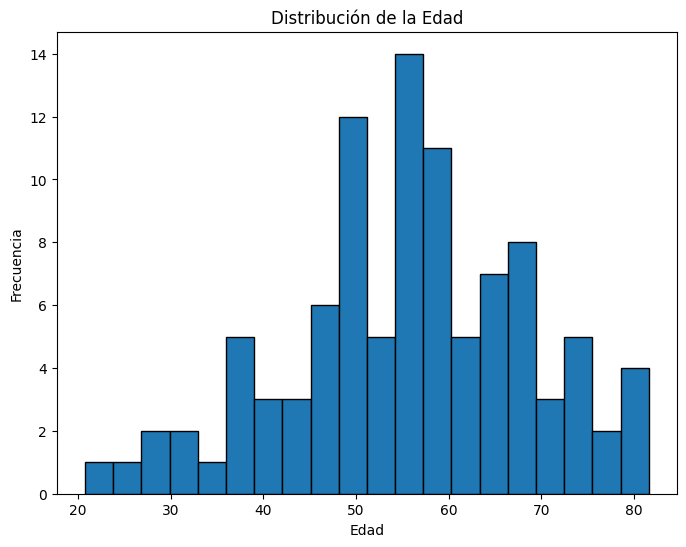

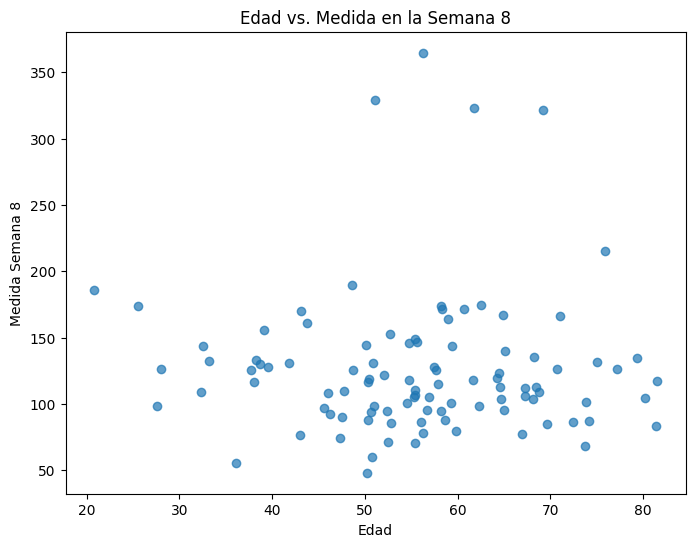

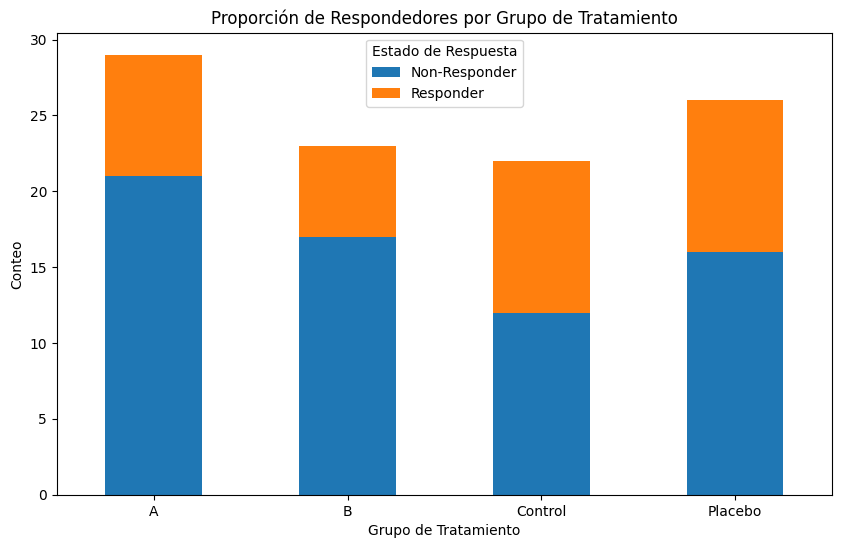

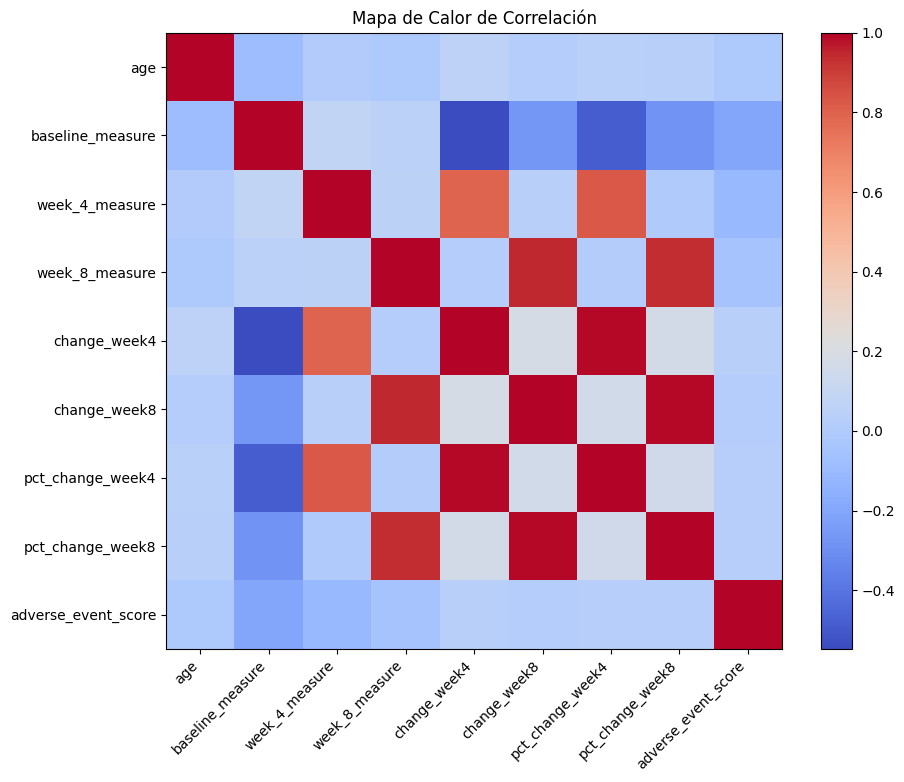

In [26]:
def visualizar_datos(df):
    """
    Genera visualizaciones para el análisis exploratorio de datos (EDA)
    """
    print("Generando visualizaciones...")

    # 1. Distribución de la edad
    plt.figure(figsize=(8, 6))
    plt.hist(df['age'], bins=20, edgecolor='black')
    plt.title('Distribución de la Edad')
    plt.xlabel('Edad')
    plt.ylabel('Frecuencia')
    plt.show()

    # 2. Comparación de medidas en grupos de tratamiento
    px.box(df, x='treatment_group', y='baseline_measure', color='treatment_group',
           title='Medidas Basales por Grupo de Tratamiento').show()

    # 3. Relación entre la edad y las medidas en la semana 8
    plt.figure(figsize=(8, 6))
    plt.scatter(df['age'], df['week_8_measure'], alpha=0.7)  # alpha para transparencia
    plt.title('Edad vs. Medida en la Semana 8')
    plt.xlabel('Edad')
    plt.ylabel('Medida Semana 8')
    plt.show()


    # 4. Proporción de respondedores por grupo de tratamiento
    treatment_responder_counts = df.groupby(['treatment_group', 'responder_status']).size().unstack(fill_value=0)
    treatment_responder_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title('Proporción de Respondedores por Grupo de Tratamiento')
    plt.xlabel('Grupo de Tratamiento')
    plt.ylabel('Conteo')
    plt.xticks(rotation=0)
    plt.legend(title='Estado de Respuesta')
    plt.show()


    # 5. Mapa de calor de correlación entre variables numéricas
    numeric_cols = ['age', 'baseline_measure', 'week_4_measure', 'week_8_measure',
                    'change_week4', 'change_week8', 'pct_change_week4', 'pct_change_week8', 'adverse_event_score']

    correlation_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.title('Mapa de Calor de Correlación')
    plt.show()

# Ejemplo de uso dentro del pipeline principal
if __name__ == "__main__":
    datos_procesados, reporte = ejecutar_pipeline_completo("/content/datos_ensayos_clinicos.csv")
    visualizar_datos(datos_procesados)